In [29]:
from transformers import BartForConditionalGeneration, BartConfig
from transformers import RobertaTokenizerFast
import torch
from torch.utils.data import DataLoader

from models import MelCAT_base
from dataset_utils import LiveMelCATDataset, MelCATCollator

from torch.nn import CrossEntropyLoss
import torch.nn.functional as F

import os
import numpy as np
import csv

from tqdm import tqdm

load_saved = True

MAX_LENGTH = 1024

roberta_tokenizer_midi = RobertaTokenizerFast.from_pretrained('/media/datadisk/data/pretrained_models/midi_mlm_tiny/midi_wordlevel_tokenizer')

bart_config = BartConfig(
    vocab_size=roberta_tokenizer_midi.vocab_size,
    pad_token_id=roberta_tokenizer_midi.pad_token_id,
    bos_token_id=roberta_tokenizer_midi.bos_token_id,
    eos_token_id=roberta_tokenizer_midi.eos_token_id,
    decoder_start_token_id=roberta_tokenizer_midi.bos_token_id,
    forced_eos_token_id=roberta_tokenizer_midi.eos_token_id,
    max_position_embeddings=MAX_LENGTH,
    encoder_layers=8,
    encoder_attention_heads=16,
    encoder_ffn_dim=4096,
    decoder_layers=8,
    decoder_attention_heads=16,
    decoder_ffn_dim=4096,
    d_model=256,
    encoder_layerdrop=0.3,
    decoder_layerdrop=0.3,
    dropout=0.3
)


# dev = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dev = torch.device("cpu")
model = MelCAT_base(bart_config, gpu=None).to(dev)

if load_saved:
    checkpoint = torch.load('saved_models/bart_base/bart_base.pt', map_location="cpu", weights_only=True)
    model.load_state_dict(checkpoint)

model.eval()

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at /media/datadisk/data/pretrained_models/midi_mlm_tiny/checkpoint-46080 and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at /media/datadisk/data/pretrained_models/chroma_mlm_tiny/checkpoint-14336 and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


MelCAT_base(
  (text_encoder): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm)

In [6]:
midifolder = '/media/datadisk/datasets/GiantMIDI-PIano/midis_v1.2/midis'
# midifolder = '/media/datadisk/data/Giant_PIano/'
dataset = LiveMelCATDataset(midifolder, segment_size=40, resolution=4, max_seq_len=1024, only_beginning=True)

/home/maximos/anaconda3/envs/torch/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [11]:
custom_collate_fn = MelCATCollator(max_seq_lens=dataset.max_seq_lengths, padding_values=dataset.padding_values)
dataloader = DataLoader(dataset, batch_size=1, collate_fn=custom_collate_fn, drop_last=True)

In [13]:
d = next(iter(dataloader))
print(d)

{'melody': {'input_ids': tensor([[ 26,  70, 157,   5,  12,  26,  68,  97,  16,  29,   5,  12,   5,  10,
          26,  92,  44,  19,  11,   5,  12,   5,   9,  91,  96,  24,  20,   5,
           8,   5,  10,  26,  88,  59,  21,  20,   5,   8,   5,  10,  26,  61,
          44,  16,  20,   5,  12,   5,  10,  62,  38,  13,  29,   5,  12,   5,
          10,  93,  52,  16,   7,   5,   9,   5,   6,  26,  70,  55,  21,   7,
           5,   9,   5,   6,  92,  59,  24,  11,   5,   8,   5,   9,  91,  96,
          36,   7,   5,  25,   5,   6,  94, 102,  21,  20,   5,   8,   5,  10,
          26,  66, 102,  16,  11,   5,  12,   5,   9,  68, 108,  21,  20,   5,
           8,   5,  10,  94, 121,  21,  11,   5,  14,   5,   9,  26,  67, 118,
          24,   7,   5,   9,   5,   6,  61,  96,  21,  20,   5,  12,   5,  10,
          91, 118,  19,  20,   5,   8,   5,  10,  26,  70,  35,  13,  11,   5,
          14,   5,   9,  92,  32,  16,   7,   5,   9,   5,   6,  90,  31,  24,
           7,   5,  25,   5

In [16]:
print(d['accomp'])

{'input_ids': tensor([[ 26,  70, 157,   5,  12,  26,  68,  37,  28,  20,   5,   8,   5,  10,
          50,  18,  11,   5,  12,   5,   9,  62,  38,  16,   7,   5,   9,   5,
           6,  64,  50,  19,   7,   5,   9,   5,   6,  69,  39,  19,   7,   5,
           9,   5,   6,  26,  70,  34,  13,  11,   5,  12,   5,   9,  90,  40,
          19,   7,   5,   9,   5,   6,  91,  41,  15,  20,   5,  12,   5,  10,
          31,  19,  29,   5,  12,   5,  10,  65,  60,  24,  11,   5,  10,   5,
           9,  62,  50,  21,   7,   5,  25,   5,   6,  93,  33,  13,  11,   5,
          14,   5,   9,  38,  16,  20,   5,   8,   5,  10,  26,  67,  37,  13,
           7,   5,  25,   5,   6,  90,  32,  21,   7,   5,   9,   5,   6,  91,
          37,  19,  20,   5,   8,   5,  10,  94,  44,  16,   7,   5,  25,   5,
           6,  64,  52,  21,  11,   5,  10,   5,   9,  69,  32,  19,   7,   5,
           9,   5,   6,  26,  67,  31,  24,   7,   5,  25,   5,   6,  90,  32,
          13,   7,   5,  10,   5,   6,

In [81]:
bos_input = {
    'input_ids' : torch.LongTensor([[roberta_tokenizer_midi.bos_token_id]]),
    'attention_mask' : torch.LongTensor([[1]])
}
logits = model(d['text'], d['melody'], d['chroma'], bos_input)
logits_full = model(d['text'], d['melody'], d['chroma'], d['accomp'])

In [20]:
import matplotlib.pyplot as plt

torch.Size([1, 1, 170])


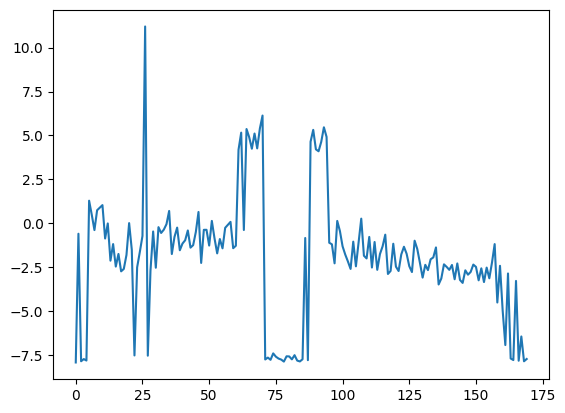

In [27]:
print(logits.shape)
plt.plot(logits[0,0,:].detach().numpy())

torch.Size([1, 1, 170])


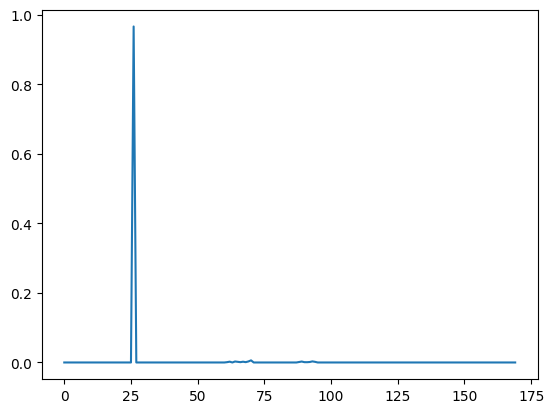

In [30]:
logits_softmax = F.softmax(logits, dim=-1)
print(logits_softmax.shape)
plt.plot(logits_softmax[0,0,:].detach().numpy())

In [35]:
def sample_with_temperature(logits, temperature=1.0):
    # Scale logits by temperature
    logits = logits / temperature
    # Apply softmax to get probabilities
    probs = F.softmax(logits, dim=-1)

    # Flatten the logits if necessary
    batch_size, seq_len, vocab_size = probs.shape
    probs = probs.view(-1, vocab_size)  # Merge batch_size and seq_len dimensions
    
    # Sample from the probability distribution
    sampled_tokens = torch.multinomial(probs, num_samples=1)
    
    # Reshape back to [batch_size, seq_len, 1]
    sampled_tokens = sampled_tokens.view(batch_size, seq_len, 1)

    # # Sample from the probability distribution
    # sampled_token = torch.multinomial(probs, num_samples=1)
    return sampled_tokens

In [98]:
sampled_full = sample_with_temperature(logits_full)
print(logits_full.shape)
print(sampled_full.shape)
print(sampled_full[:][-1][:].reshape(1,-1).shape)

torch.Size([1, 439, 170])
torch.Size([1, 439, 1])
torch.Size([1, 439])


In [36]:
temperature = 0.7  # Adjust temperature as needed
sampled_tokens = sample_with_temperature(logits, temperature)
print(sampled_tokens)

tensor([[[26]]])


In [43]:
print(sampled_tokens[0][0][-1])
print(roberta_tokenizer_midi.eos_token_id)
print(sampled_tokens[0][0][-1] != roberta_tokenizer_midi.eos_token_id)

tensor(26)
2
tensor(True)


In [58]:
x = torch.cat( (bos_input['input_ids'], sampled_tokens[:][:][-1]), -1)

In [60]:
print(x.shape)
print(d['accomp']['input_ids'].shape)

torch.Size([1, 2])
torch.Size([1, 439])


In [71]:
y = torch.cat( (x, sampled_tokens[:][-1:][-1]), 1)
print(y)

tensor([[ 1, 26, 26]])


In [56]:
torch.cat( (bos_input['attention_mask'], torch.full(sampled_tokens[:][:][-1].shape,1)), -1)

tensor([[1, 1]])

In [101]:
def generate_bart_base(d, temperature=1.0, max_seq_len=4096):
    accomp_input = {
        'input_ids' : torch.LongTensor([[roberta_tokenizer_midi.bos_token_id]]),
        'attention_mask' : torch.LongTensor([[1]])
    }
    logits = model(d['text'], d['melody'], d['chroma'], accomp_input)
    sampled_tokens = sample_with_temperature(logits, temperature)
    while sampled_tokens[0][0][-1] != roberta_tokenizer_midi.eos_token_id and accomp_input['input_ids'].shape[-1] < max_seq_len:
        print('accomp_input[input_ids]:', accomp_input['input_ids'].shape)
        print(sampled_tokens[:][:][-1].shape)
        accomp_input['input_ids'] = torch.cat( (accomp_input['input_ids'], sampled_tokens[:][-1][:].reshape(1,-1)), -1)
        accomp_input['attention_mask'] = torch.cat( (accomp_input['attention_mask'], torch.full(sampled_tokens[:][-1][:].reshape(1,-1).shape,1)), -1)
        logits = model(d['text'], d['melody'], d['chroma'], accomp_input)
        sampled_tokens = sample_with_temperature(logits, temperature)
        print(accomp_input['input_ids'])
    return accomp_input

In [102]:
a = generate_bart_base(d)

accomp_input[input_ids]: torch.Size([1, 1])
torch.Size([1, 1])
tensor([[ 1, 26]])
accomp_input[input_ids]: torch.Size([1, 2])
torch.Size([2, 1])
tensor([[ 1, 26, 26, 70]])
accomp_input[input_ids]: torch.Size([1, 4])
torch.Size([4, 1])
tensor([[  1,  26,  26,  70,  26,  70,  70, 157]])
accomp_input[input_ids]: torch.Size([1, 8])
torch.Size([8, 1])
tensor([[  1,  26,  26,  70,  26,  70,  70, 157,  26,  70,  70, 157,  70, 157,
         157,   5]])
accomp_input[input_ids]: torch.Size([1, 16])
torch.Size([16, 1])
tensor([[  1,  26,  26,  70,  26,  70,  70, 157,  26,  70,  70, 157,  70, 157,
         157,   5,  26,  70,  70, 157,  70, 157, 157,   5,  63, 157, 157, 157,
         157,   5,   5,  12]])
accomp_input[input_ids]: torch.Size([1, 32])
torch.Size([32, 1])
tensor([[  1,  26,  26,  70,  26,  70,  70, 157,  26,  70,  70, 157,  70, 157,
         157,   5,  26,  70,  70, 157,  70, 157, 157,   5,  63, 157, 157, 157,
         157,   5,   5,  12,  26,  70,  70, 157,  70, 157, 157,   5,  70, 

In [103]:
print(a['input_ids'].shape)

torch.Size([1, 4096])
